In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['stackoverflow', 'stackoverflow-1-clean-questions-file']


In [2]:
df_tags = pd.read_csv('../input/stackoverflow/Tags.csv', encoding='iso-8859-1')

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# magic function
%matplotlib inline
def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/4000 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(9,8))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()

[('javascript', 124155), ('java', 115212), ('c#', 101186), ('php', 98808), ('android', 90659), ('jquery', 78542), ('python', 64601), ('html', 58976), ('c++', 47591), ('ios', 47009)]


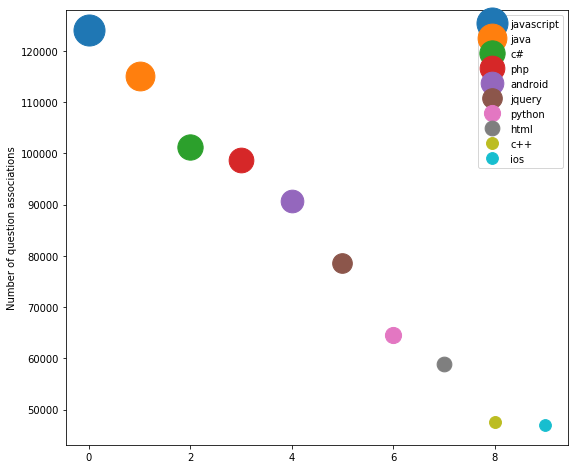

In [4]:
import collections
tagCount =  collections.Counter(list(df_tags['Tag'])).most_common(10)
print(tagCount)
plot_tags(tagCount)

In [5]:
top10=['javascript','java','c#','php','android','jquery','python','html','c++','ios']

In [6]:
tag_top10= df_tags[df_tags.Tag.isin(top10)]
print (tag_top10.shape)
tag_top10.head()

(826739, 2)


,Id,Tag
14,260,c#
18,330,c++
28,650,c#
35,930,c#
39,1010,c#


In [7]:
tag_top10['Id'].value_counts().head(10)

30798790    5
31085960    5
11648170    5
35318730    5
4009250     5
30289880    5
23267320    5
35283570    5
30991580    5
23484760    5
Name: Id, dtype: int64

In [8]:
tag_top10.head()

,Id,Tag
14,260,c#
18,330,c++
28,650,c#
35,930,c#
39,1010,c#


In [9]:
def add_tags(question_id):
    return tag_top10[tag_top10['Id'] == question_id['Id']].Tag.values

top10 = tag_top10.apply(add_tags, axis=1)

In [10]:
len(top10),tag_top10.shape

(826739, (826739, 2))

In [11]:
tag_top10=pd.concat([tag_top10, top10.rename('Tags')], axis=1)

In [12]:
tag_top10.head()

,Id,Tag,Tags
14,260,c#,[c#]
18,330,c++,[c++]
28,650,c#,[c#]
35,930,c#,[c#]
39,1010,c#,[c#]


In [13]:
tag_top10.drop(["Tag"], axis=1, inplace=True)

In [14]:
tag_top10.shape

(826739, 2)

In [15]:
top10_tags=tag_top10.loc[tag_top10.astype(str).drop_duplicates().index]

In [16]:
ques = pd.read_csv('../input/stackoverflow-1-clean-questions-file/question_clean.csv', encoding='iso-8859-1')

In [17]:
total=pd.merge(ques, top10_tags, on='Id')
print(total.shape)
total.head()

(706336, 3)


,Id,Content,Tags
0,260,Adding scripting functionality to .NET applica...,[c#]
1,330,Should I use nested classes in this case? I am...,[c++]
2,650,Automatically update version number I would li...,[c#]
3,930,How do I connect to a database and loop over a...,[c#]
4,1010,"How to get the value of built, encoded ViewSta...",[c#]


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, GRU
from keras.models import Model

Using TensorFlow backend.


In [19]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(total.Tags)
labels = multilabel_binarizer.classes_
labels

array(['android', 'c#', 'c++', 'html', 'ios', 'java', 'javascript',
       'jquery', 'php', 'python'], dtype=object)

In [20]:
train,test=train_test_split(total[:550000],test_size=0.25,random_state=24)

In [21]:
train.shape,test.shape

((412500, 3), (137500, 3))

In [22]:
X_train=train['Content']
y_train=multilabel_binarizer.transform(train['Tags'])
X_test=test['Content']
y_test=multilabel_binarizer.transform(test['Tags'])

In [23]:
sent_lens=[]
for sent in train['Content']:
    sent_lens.append(len(word_tokenize(sent)))

In [24]:
max(sent_lens)

20864

In [25]:
np.quantile(sent_lens,0.95)

836.0

In [26]:
max_len = 800
tok = Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(X_train)
sequences_train = tok.texts_to_sequences(X_train)

In [27]:
vocab_len=len(tok.index_word.keys())

In [28]:
vocab_len

1298781

In [29]:
sequences_matrix_train = sequence.pad_sequences(sequences_train,maxlen=max_len)

In [30]:
sequences_matrix_train

array([[   0,    0,    0, ...,   52, 2068,   87],
       [   0,    0,    0, ..., 1374,  210,  778],
       [   0,    0,    0, ...,   35,   52,   88],
       ...,
       [   0,    0,    0, ...,   20,   70,  713],
       [   0,    0,    0, ...,  199,   60,   10],
       [   0,    0,    0, ...,  202,  180,   10]], dtype=int32)

In [31]:
sequences_matrix_train.shape

(412500, 800)

In [32]:
sequences_test = tok.texts_to_sequences(X_test)
sequences_matrix_test = sequence.pad_sequences(sequences_test,
                                               maxlen=max_len)

In [33]:
sequences_matrix_train.shape,sequences_matrix_test.shape,y_train.shape,y_test.shape

((412500, 800), (137500, 800), (412500, 10), (137500, 10))

In [34]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(vocab_len+1,210,input_length=max_len,mask_zero=True)(inputs)
    layer = GRU(250)(layer)
    layer = Dense(500,name='FC1')(layer)
    layer = Activation('relu')(layer) 
    layer = Dense(300,name='FC2')(layer)
    layer = Activation('relu')(layer) 
    layer = BatchNormalization()(layer) 
    layer = Dropout(0.3)(layer)
    layer = Dense(100,name='FC3')(layer)
    layer = Activation('relu')(layer) 
    layer = BatchNormalization()(layer) 
    layer = Dropout(0.3)(layer)
    layer = Dense(10,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [35]:
model = RNN()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 800)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 800, 210)          272744220 
_________________________________________________________________
gru_1 (GRU)                  (None, 250)               345750    
_________________________________________________________________
FC1 (Dense)                  (None, 500)               125500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
FC2 (Dense)          

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
type(y_train),type(sequences_matrix_train)

(numpy.ndarray, numpy.ndarray)

In [38]:
#model.fit(sequences_matrix_train,y_train,batch_size=50,epochs=50,validation_data=(sequences_matrix_test,y_test))

In [39]:
bat_siz=800

In [40]:
def batch_generator(X, y, batch_size=32):
    '''
    Return a random from X, y
    '''
    
    while True:
        # choose batch_size random images / labels from the data
        idx = np.random.randint(0, X.shape[0], batch_size)
        im = X[idx]
        label = y[idx]
        
        yield im, label

train_gen = batch_generator(sequences_matrix_train, y_train, batch_size=bat_siz)
valid_gen = batch_generator(sequences_matrix_test, y_test, batch_size=bat_siz)


In [41]:
results=model.fit_generator(
    generator=train_gen,
    epochs=5,
    steps_per_epoch=sequences_matrix_train.shape[0] // bat_siz,
    validation_data=valid_gen,
    validation_steps=sequences_matrix_test.shape[0] // bat_siz)

Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:107: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 272744220 elements. This may consume a large amount of memory.
  num_elements)


Epoch 1/5
515/515 [==============================] - 1131s 2s/step - loss: 1.4579 - acc: 0.5949 - val_loss: 0.8266 - val_acc: 0.8012
Epoch 2/5
515/515 [==============================] - 1102s 2s/step - loss: 0.6818 - acc: 0.8466 - val_loss: 0.7120 - val_acc: 0.8364
Epoch 3/5
515/515 [==============================] - 1104s 2s/step - loss: 0.5574 - acc: 0.8705 - val_loss: 0.7116 - val_acc: 0.8393
Epoch 4/5
515/515 [==============================] - 1108s 2s/step - loss: 0.4861 - acc: 0.8834 - val_loss: 0.7216 - val_acc: 0.8302
Epoch 5/5
515/515 [==============================] - 1105s 2s/step - loss: 0.4361 - acc: 0.8931 - val_loss: 0.7538 - val_acc: 0.8273


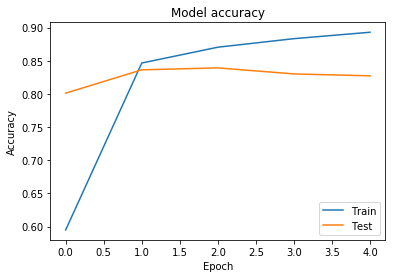

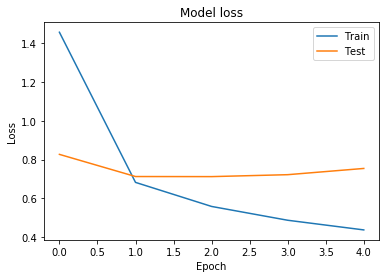

In [42]:
# Plot training & validation accuracy values
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [43]:
model.save_weights('./stackoverflow_tags.h5', overwrite=True)

In [44]:
model.save('./stackoverflow_tags.h5')